In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import textacy

def get_webpage(url):
    """
    makes HTTP GET request to get content of 'url'
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    
    print(e)

In [2]:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from string import punctuation
from heapq import nlargest
import nltk
nltk.download('stopwords')
nltk.download('punkt')

class FrequencySummarizer:
    def __init__(self, min_cut=0.1, max_cut=0.9):
        """
         Initilize the text summarizer.
         Words that have a frequency term lower than min_cut 
         or higer than max_cut will be ignored.
        """
        self._min_cut = min_cut
        self._max_cut = max_cut 
        self._stopwords = set(stopwords.words('english') + list(punctuation))


    def compute_freq(self, word_sent):
        """ 
          Compute the frequency of each of word.
          Input: 
           word_sent, a list of sentences already tokenized.
          Output: 
           freq, a dictionary where freq[w] is the frequency of w.
        """
        freq = defaultdict(int)
        for item in word_sent:
            for word in item:
                if word not in self._stopwords:
                    freq[word] += 1
        m = float(max(freq.values()))
        freq2 = freq.copy()
        for w in freq.keys():
            freq[w] = freq[w]/m
            if freq[w] >= self._max_cut or freq[w] <= self._min_cut:
                del freq2[w]
        return freq2
    
    def summarize(self, text, n):
        """
          return a list of n sentences 
          that present summary of the text.
        """
        sents = nltk.sent_tokenize(text)
        assert n <= len(sents)
        word_sent = [word_tokenize(s.lower()) for s in sents]
        self._freq = self.compute_freq(word_sent)
        ranking = defaultdict(int)
        for i,sent in enumerate(word_sent):
            for w in sent:
                if w in self._freq:
                    ranking[i] += self._freq[w]
        sents_idx = self.rank(ranking, n)    
        return [sents[j] for j in sents_idx]

    def rank(self, ranking, n):
        """ 
          return the first n sentences with highest ranking
        """
        return nlargest(n, ranking, key=ranking.get)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartlomiejkos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bartlomiejkos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def clean_text(text):
    text = text.replace('\r', ' ').replace('\n', ' ').replace('\t',' ').replace('\xa0',' ')
    text = text.replace('Physics Today', ' ')
    return text

In [4]:
nlp = spacy.load('en_core_web_lg')
wbpg = get_webpage('https://physicstoday.scitation.org/department/all-departments?pageSize=200')
soup = BeautifulSoup(wbpg, 'html.parser')
articles = soup.find_all('article')
wbpgs = []
for link in articles:
    item = link.find('a')
    item = 'https://physicstoday.scitation.org' + item.get('href')
    wbpgs.append(item)

Metamaterials solve integral equations


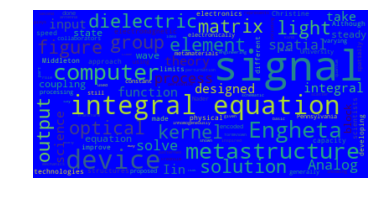

['Inspired by the idea, Engheta’s group has now used metastructures as part of a basic analog optical computer, a schematic of which is shown in the figure, that can solve integral equations.The devices are designed to solve integral equations that take the formKnown as Fredholm integral equations of the second kind, they come up in many areas of science and engineering, including antenna theory and perturbation theory in quantum mechanics.', 'Then the integral equation can be recast as a matrix relation in which the integral over K is a matrix and an algorithm translates the matrix’s elements into a spatial distribution of dielectric material for the metastructure.Each of the N values of u at which the equation is evaluated has a corresponding waveguide (loops in the figure) that allows the signal to flow around the network and through a coupling element where Iin is introduced (orange block).']
A glimpse of a planetary system’s final stages


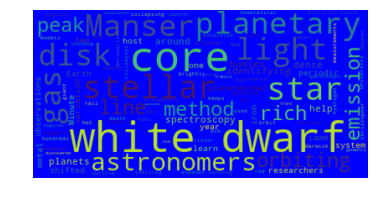

['Now Christopher Manser (University of Warwick) and colleagues have used a new spectroscopic method to identify a planetesimal orbiting a white dwarf 400 light-years from our solar system.Astronomers have discovered most exoplanets—including an asteroid-like body orbiting a white dwarf—via the transit method, identifying periodic dimming as an object passes in front of its host star.', 'Calculations suggested that a core rich in iron and nickel would be sufficiently dense and strong to resist being torn apart by the white dwarf’s gravity.Future observations with the next generation of large ground telescopes could help astronomers learn about the chemical composition and structure of planetary cores.']
Inverted kinetics in concerted charge transfer


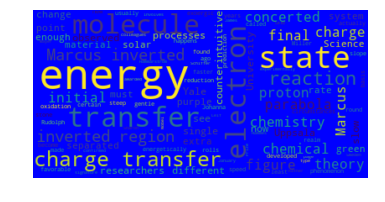

['When the molecule is prepared in a charge-separated state—with an extra proton bound to the nitrogen atom in the upper right and an extra electron on the trio of fused benzene rings in the lower left—it relaxes back to the ground state through a concerted transfer of the two charged particles to the middle of the molecule.Marcus’s theory stems from the insight that charge transfer can proceed only when the initial and final states have both the same energy and the same geometry.', 'But 60 years ago, when Rudolph Marcus developed his theory of electron transfer—the basis for all oxidation and reduction chemistry—he found that under certain circumstances, the transfer should actually slow down when it’s made more exoergic.That counterintuitive prediction—the so-called Marcus inverted region—was experimentally confirmed in 1984, and in 1992 Marcus was awarded the Nobel Prize in Chemistry for his theory (see  , January 1993, page 20).']
Study quantifies the growing traction of open acces

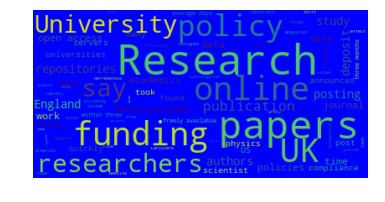

['The bibliometric data came from CORE, a website that aggregates data about scholarly publications from online repositories, including preprint servers such as arXiv and institutional servers like White Rose Research Online, a collection of work from the UK’s Universities of Leeds, Sheffield, and York.The authors found that in 2017, researchers took an average of 135 days following publication to deposit their papers in an online repository.', 'In February the University of California system announced that it had canceled its subscription contract with Elsevier.Daniel Himmelstein, a data scientist at the University of Pennsylvania, says it’s possible the new study has a large selection bias, since it doesn’t consider papers that weren’t deposited at all.The authors found many repositories where more than 90% of the material had been posted within three months of publication in a journal, but they also found many sites with less than 50% compliance with the Research England policy.']


In [5]:
for i in range(4):
    site = get_webpage(wbpgs[i])
    site = BeautifulSoup(site, 'html.parser')
    title = site.title.string
    try:
        author = i.find('div', attrs={'class':'entryAuthor'}).get_text().strip()
    except:
        author = 'Unknown / Anonym'
    paragraphs = site.findAll('p')
    new = ''
    for item in paragraphs:
        new += item.text
    new = clean_text(new)
    fs = FrequencySummarizer()
    print(title)
    wc = WordCloud(max_font_size=50, relative_scaling=0.7, max_words=100, background_color='blue').generate(new)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig('/Users/bartlomiejkos/Documents/ProgrammingNew/Python/show me your letters/blackholemap.png')
    plt.show()
    print(fs.summarize(new,2))